# Know Your Data 2 - Powercell

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler

## Comment on features

#### Core features

* **bid/ask:** provides intel on the supply and demand of the asset. Question is if we also want to engineer a new feature as the bid ask spread? Lets keep that in our toolbox for now. 
* **ohlc:** this one we know, straight up. Obviously we will use this to generate our suite of technical indicators.
* **average price:** this one feels redundant but it might be useful to use in step_2 in the TDQN trading routine. Note also that this is the average of ohlc and bid/ask. Lets keep it for now.
* **volume:** total number of shares traded. Keep an eye on how it lands with normalization due to its large number.
* **turnover:** same here with the large numbers.
* **number of trades:** gives intel on large events etc.

#### Technical features

* We use the same as in previous attempts. That is MA and EM, perhaps add RSI if we feel up for it one day. We compute them on raw price average data.
* Removing ma200, the cost in loss of data is just to large.
* Yeea, im gonna ditch ma50 aswell, its just not worth it with this small dataset. Every datapoint counts here.

#### Macro

* **omx:** a simple average price feature of omx30.
 
#### Approach 

* **returns:** we want to center our distributions around zero. Hence it is natural to make use of the returns of all the features, including the technical ones. (this is new for us).
* **normalize:** We will normalize the full dataset in one go.

#### Outliers

* Clipping everything outside 3 std column-wise. Not removing, they remain in the dataset.

#### Test

* Slicing the dataset at 1315, giving it a good 100 days or so for test.

In [5]:
names = ['date', 'price', 'avg_p', 'bid', 'ask', 'o', 'h', 'l', 'c', 'avgp', 'vol', 'oms', 'num']
df = pd.read_csv('pcell.csv', sep=';', header=1).iloc[:,:1]
df[[1, 2]] = pd.read_csv('pcell.csv', sep=';', header=1).iloc[:,6:8]
df = pd.concat([df, pd.read_csv('pcell.csv', sep=';', header=1).iloc[:,:-1].drop(
    columns=['Date'])], axis=1).iloc[::-1].reset_index().drop(columns='index')
df.columns = names
df

,date,price,avg_p,bid,ask,o,h,l,c,avgp,vol,oms,num
0,2015-01-02,"6,95","6,835","6,85","6,95","6,70","7,00","6,45","6,95","6,835",178406.0,"1219377,6",191
1,2015-01-05,"7,30","7,285","7,25","7,30","7,00","7,40","7,00","7,30","7,285",141472.0,"1030612,4",178
2,2015-01-07,"7,10","7,131","6,95","7,10","7,30","7,30","6,95","7,10","7,131",155764.0,"1110700,65",145
3,2015-01-08,"7,00","6,914","6,85","7,00","7,30","7,30","6,60","7,00","6,914",111946.0,773976,106
4,2015-01-09,"6,70","6,843","6,60","6,70","7,00","7,05","6,60","6,70","6,843",56771.0,"388478,7",68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2020-09-21,"216,00","220,275","215,20","216,60","233,00","234,00","214,60","216,00","220,275",571343.0,"125856751,8",6144
1437,2020-09-22,"223,60","225,985","222,00","223,00","218,00","230,60","218,00","223,60","225,985",329239.0,"74405798,9",2997
1438,2020-09-23,"222,40","223,551","222,40","222,80","226,00","226,80","220,20","222,40","223,551",136801.0,"30581937,8",1485
1439,2020-09-24,"209,40","211,231","209,20","210,80","217,80","219,00","206,80","209,40","211,231",415275.0,87718846,3859


In [6]:
# Filter out null
for name in names:
    no_null = []
    # check if null exist in column
    if any(df[name].isnull()):
        # traverse the boolean dataframe
        for i, j in enumerate(df[name].isnull()):
            if not j:
                # hold a value from latest non null
                tmp = df[name].iloc[i]
                no_null.append(tmp)
            else:
                no_null.append(tmp)
        # put back in dataframe
        df[name] = pd.Series(no_null)
# Get float from string
for name in names[1:]:
    if type(df[name].iloc[1]) == str:
        df[name] = pd.Series([float(i.replace(',', '.')) for i in df[name]])

# Moving averages
ma_sizes = (26,)
ma = {i: [] for i in ma_sizes}
for size in ma_sizes:
    for i in range(len(df)):
        if i <= size:
            ma[size].append(np.average(df['price']))
        else:
            value = sum(df['price'].values[i - size: i]) / size
            ma[size].append(value)   
# Exponential moving average
smoother = 2
em_sizes = (12, 20, 26)
em = {i: [] for i in em_sizes}
for size in em_sizes:
    em_t = sum(df['price'][:size]) / size
    for i in range(len(df)):
        if i <= size:
            em[size].append(0)
        else:
            em_t = (df['price'][i] * (smoother / (1 + size)) + (em_t * (1 - (smoother / (1 + size)))))
            em[size].append(em_t)
# MACD
macd1 = [i - j for i, j in zip(em[12], em[26])]
macd2 = []
macd3 = []
em_t = sum(macd1[:9]) / 9
for i in range(len(macd1)):
    if i <= 9:
        macd2.append(0)
    else:
        em_t = (macd1[i] * (smoother / (1 + size)) + (em_t * (1 - (smoother / (1 + size)))))
        macd2.append(em_t)
macd3 = [i - j for i, j in zip(macd1, macd2)]
tech = [ma[26], em[12], em[26], macd1, macd2, macd3]
names_df2 = ['ma1', 'em1', 'em2', 'md1', 'md2', 'md3']
names2 = names + names_df2
df2 = pd.DataFrame({i: j for i, j in zip(names_df2, tech)})
# slice the first 26 rows
df3 = pd.concat([df, df2], axis=1).iloc[27:]
df3

,date,price,avg_p,bid,ask,o,h,l,c,avgp,vol,oms,num,ma1,em1,em2,md1,md2,md3
27,2015-02-11,5.40,5.280,5.35,5.40,5.20,5.45,5.15,5.40,5.280,25047.0,1.322442e+05,40,6.186538,5.682923,6.190598,-0.507675,3.706302,-4.213977
28,2015-02-12,5.60,5.548,5.50,5.60,5.40,5.60,5.40,5.60,5.548,43817.0,2.431072e+05,59,6.113462,5.670166,6.146850,-0.476684,3.396451,-3.873135
29,2015-02-13,5.75,5.637,5.60,5.75,5.60,5.75,5.50,5.75,5.637,28446.0,1.603465e+05,39,6.055769,5.682448,6.117454,-0.435006,3.112639,-3.547645
30,2015-02-16,5.90,5.807,5.80,5.90,5.75,5.95,5.55,5.90,5.807,52512.0,3.049355e+05,124,6.007692,5.715918,6.101346,-0.385429,2.853523,-3.238952
31,2015-02-17,5.95,5.778,5.90,5.95,5.90,5.95,5.65,5.95,5.778,35155.0,2.031181e+05,94,5.976923,5.751930,6.090135,-0.338205,2.617099,-2.955304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2020-09-21,216.00,220.275,215.20,216.60,233.00,234.00,214.60,216.00,220.275,571343.0,1.258568e+08,6144,244.100000,231.730145,241.425224,-9.695079,-9.541191,-0.153888
1437,2020-09-22,223.60,225.985,222.00,223.00,218.00,230.60,218.00,223.60,225.985,329239.0,7.440580e+07,2997,242.046154,230.479354,240.104837,-9.625483,-9.547435,-0.078049
1438,2020-09-23,222.40,223.551,222.40,222.80,226.00,226.80,220.20,222.40,223.551,136801.0,3.058194e+07,1485,240.515385,229.236376,238.793368,-9.556991,-9.548143,-0.008849
1439,2020-09-24,209.40,211.231,209.20,210.80,217.80,219.00,206.80,209.40,211.231,415275.0,8.771885e+07,3859,238.492308,226.184626,236.616081,-10.431455,-9.613573,-0.817882


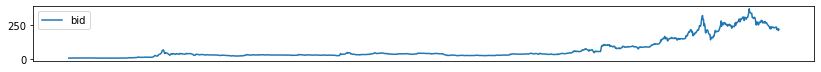

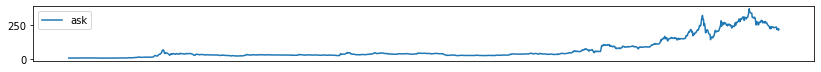

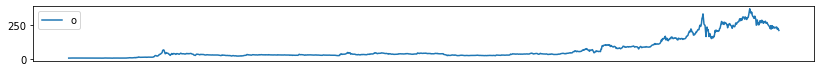

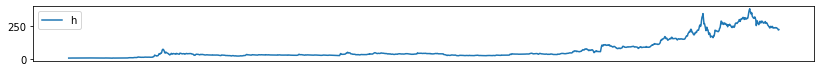

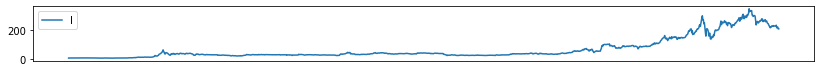

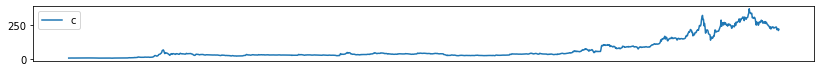

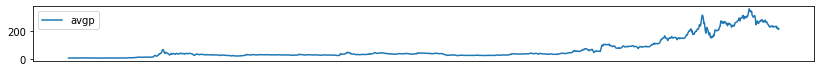

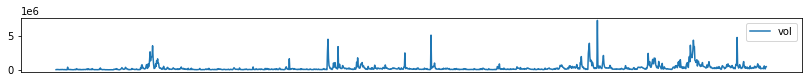

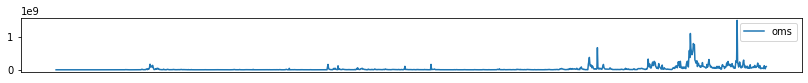

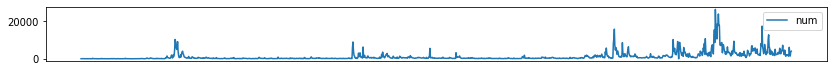

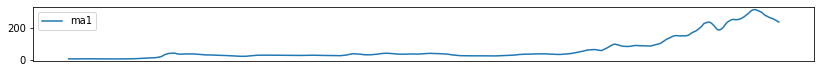

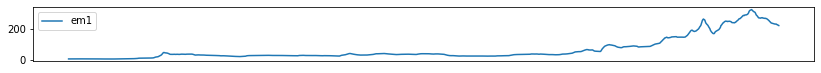

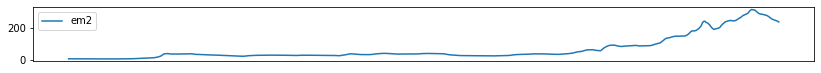

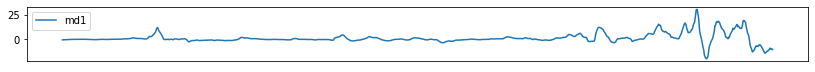

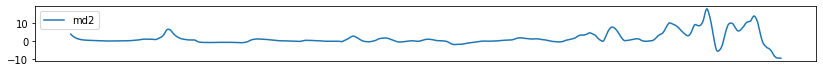

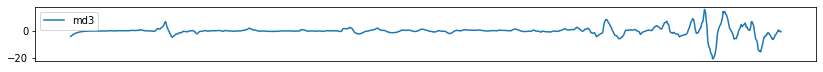

In [59]:
# Raw curves
for i, j in enumerate(names2[3:]):
    plt.figure(figsize=(14, 1))
    plt.plot(df3[j], label=j)
    plt.xticks([])
    plt.legend(loc='best')
    plt.show()

In [7]:
# get diff and pct change
diff = df3[['vol', 'oms', 'num']].diff()
pct = df3[['bid', 'ask', 'o', 'h', 'l', 'c', 'avgp'] + names_df2].pct_change()
diff_pct = pd.concat([pct, diff], axis=1)
diff_pct.columns = [
    name + '_' for name in ['bid', 'ask', 'o', 'h', 'l', 'c', 'avgp'] + names_df2 + ['vol', 'oms', 'num']]
df4 = pd.concat([df3, diff_pct], axis=1).iloc[1:].reset_index().drop(columns='index')
names3 = df4.columns
# clipping outliers
for name in diff_pct.columns.tolist():
    df4[[name]] = df4[[name]].clip(- 3 *df4[name].std(), 3 * df4[name].std())
df4

,date,price,avg_p,bid,ask,o,h,l,c,avgp,...,avgp_,ma1_,em1_,em2_,md1_,md2_,md3_,vol_,oms_,num_
0,2015-02-12,5.60,5.548,5.5,5.60,5.40,5.60,5.40,5.60,5.548,...,0.050758,-0.011812,-0.002245,-0.007067,-0.061044,-0.083601,-0.080884,18770.0,110863.00,19.000000
1,2015-02-13,5.75,5.637,5.6,5.75,5.60,5.75,5.50,5.75,5.637,...,0.016042,-0.009437,0.002166,-0.004782,-0.087434,-0.083561,-0.084038,-15371.0,-82760.70,-20.000000
2,2015-02-16,5.90,5.807,5.8,5.90,5.75,5.95,5.55,5.90,5.807,...,0.030158,-0.007939,0.005890,-0.002633,-0.113969,-0.083246,-0.087014,24066.0,144589.00,85.000000
3,2015-02-17,5.95,5.778,5.9,5.95,5.90,5.95,5.65,5.95,5.778,...,-0.004994,-0.005122,0.006300,-0.001837,-0.122522,-0.082853,-0.087574,-17357.0,-101817.40,-30.000000
4,2015-02-18,5.85,5.716,5.6,5.85,5.95,5.95,5.55,5.85,5.716,...,-0.010730,-0.004826,0.002623,-0.002921,-0.097206,-0.082716,-0.084374,1714.0,7614.10,-45.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,2020-09-21,216.00,220.275,215.2,216.60,233.00,234.00,214.60,216.00,220.275,...,-0.063078,-0.005796,-0.012192,-0.008355,0.093134,0.001292,-1.233231,404681.0,86673717.50,4239.024179
1409,2020-09-22,223.60,225.985,222.0,223.00,218.00,230.60,218.00,223.60,225.985,...,0.025922,-0.008414,-0.005398,-0.005469,-0.007178,0.000654,-0.492821,-242104.0,-51450952.90,-3147.000000
1410,2020-09-23,222.40,223.551,222.4,222.80,226.00,226.80,220.20,222.40,223.551,...,-0.010771,-0.006324,-0.005393,-0.005462,-0.007116,0.000074,-0.886624,-192438.0,-43823861.10,-1512.000000
1411,2020-09-24,209.40,211.231,209.2,210.80,217.80,219.00,206.80,209.40,211.231,...,-0.055110,-0.008411,-0.013313,-0.009118,0.091500,0.006853,13.097793,278474.0,57136908.20,2374.000000


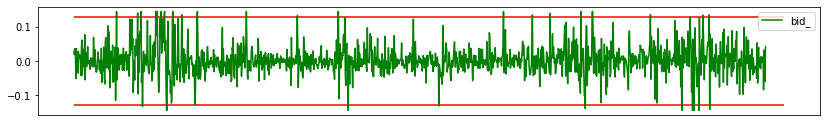

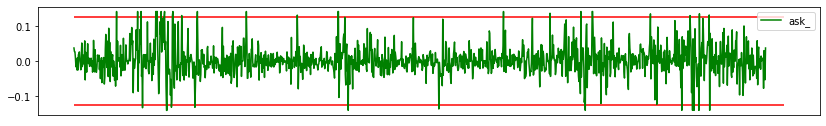

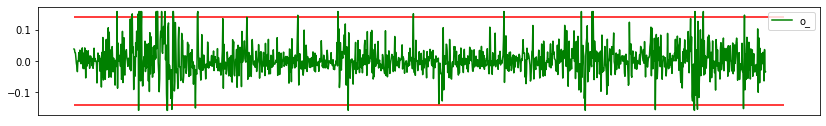

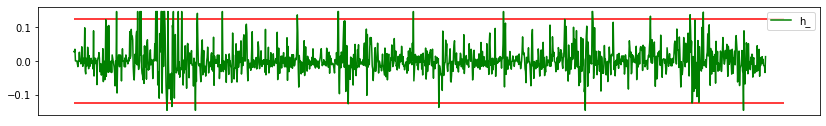

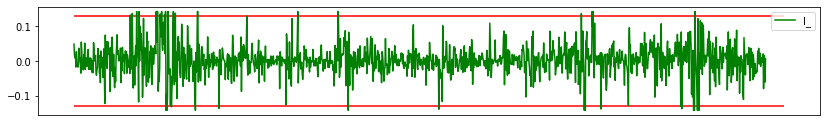

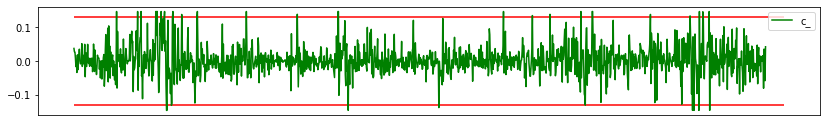

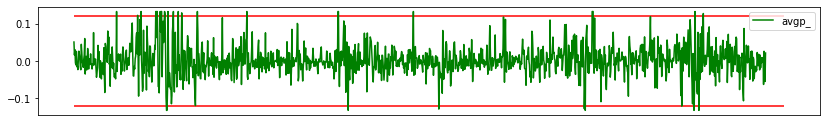

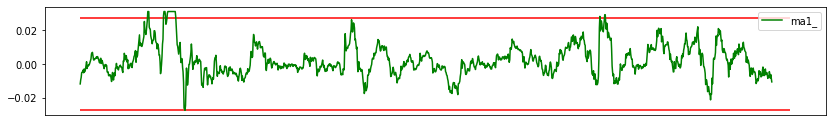

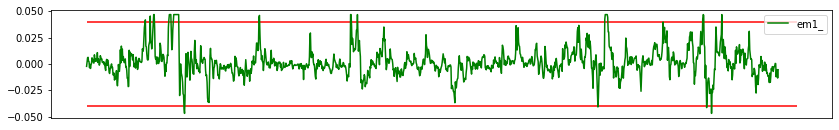

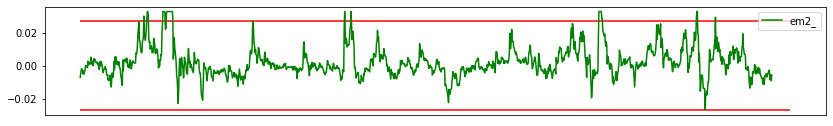

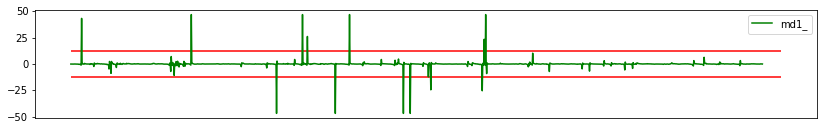

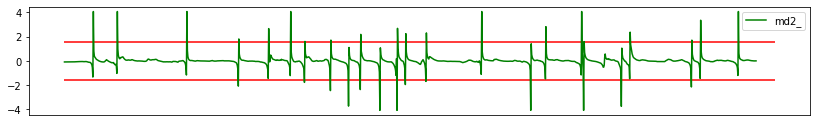

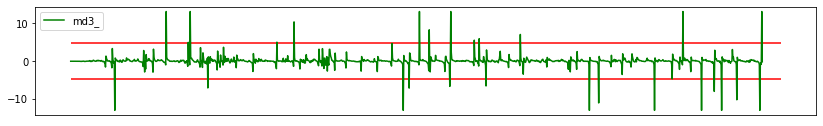

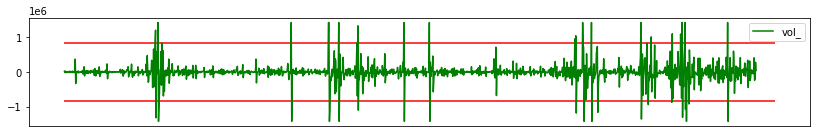

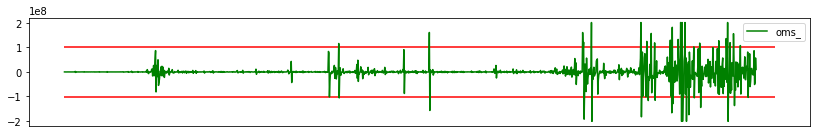

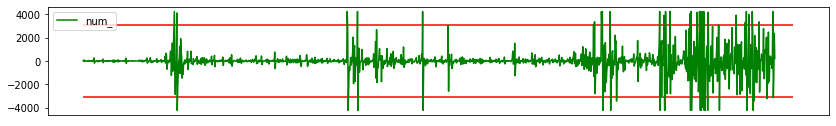

In [8]:
for i, j in enumerate(diff_pct.columns.tolist()):
    plt.figure(figsize=(14, 2))
    plt.plot(df4[j], 'g', label=j)
    plt.hlines(- 3 *df4[j].std(), 0, 1450, 'r')
    plt.hlines(3 * df4[j].std(), 0, 1450, 'r')
    plt.xticks([])
    plt.legend(loc='best')
    plt.show()

In [9]:
# Normalizing
scaler = StandardScaler()
norm = scaler.fit_transform(
    df4[list(diff_pct.columns)].values.reshape(-1, len(list(diff_pct.columns))))
# split into train and test
X_train = norm[:1315]
X_test = norm[1315:]
train = df4.iloc[:1315]
test = df4.iloc[1315:].reset_index().drop(columns='index')
data = df4

In [10]:
X_train.shape

(1315, 16)

In [11]:
X_test.shape

(98, 16)

In [12]:
train

,date,price,avg_p,bid,ask,o,h,l,c,avgp,...,avgp_,ma1_,em1_,em2_,md1_,md2_,md3_,vol_,oms_,num_
0,2015-02-12,5.60,5.548,5.5,5.60,5.40,5.60,5.40,5.60,5.548,...,0.050758,-0.011812,-0.002245,-0.007067,-0.061044,-0.083601,-0.080884,18770.0,110863.0,19.0
1,2015-02-13,5.75,5.637,5.6,5.75,5.60,5.75,5.50,5.75,5.637,...,0.016042,-0.009437,0.002166,-0.004782,-0.087434,-0.083561,-0.084038,-15371.0,-82760.7,-20.0
2,2015-02-16,5.90,5.807,5.8,5.90,5.75,5.95,5.55,5.90,5.807,...,0.030158,-0.007939,0.005890,-0.002633,-0.113969,-0.083246,-0.087014,24066.0,144589.0,85.0
3,2015-02-17,5.95,5.778,5.9,5.95,5.90,5.95,5.65,5.95,5.778,...,-0.004994,-0.005122,0.006300,-0.001837,-0.122522,-0.082853,-0.087574,-17357.0,-101817.4,-30.0
4,2015-02-18,5.85,5.716,5.6,5.85,5.95,5.95,5.55,5.85,5.716,...,-0.010730,-0.004826,0.002623,-0.002921,-0.097206,-0.082716,-0.084374,1714.0,7614.1,-45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2020-05-04,242.00,237.810,241.4,243.00,230.00,243.80,230.00,242.00,237.810,...,-0.066779,0.014253,-0.006542,0.000805,-0.138302,0.015397,-0.520910,136721.0,29425929.6,1861.0
1311,2020-05-05,258.00,252.727,253.2,256.00,245.80,258.00,245.80,258.00,252.727,...,0.062727,0.008412,0.004231,0.005691,-0.026177,0.011733,-0.226189,-92509.0,-18633380.6,-1579.0
1312,2020-05-06,252.00,255.213,252.6,254.00,256.20,258.20,252.00,252.00,255.213,...,0.009837,0.007113,-0.000095,0.003395,-0.075187,0.004361,-0.623926,-47530.0,-11569314.0,-303.0
1313,2020-05-07,255.80,251.758,253.4,253.80,252.00,255.80,247.20,255.80,251.758,...,-0.013538,0.006822,0.002238,0.004297,-0.045829,0.000442,-0.898260,31714.0,7368739.4,-52.0


In [13]:
test

,date,price,avg_p,bid,ask,o,h,l,c,avgp,...,avgp_,ma1_,em1_,em2_,md1_,md2_,md3_,vol_,oms_,num_
0,2020-05-11,246.8,248.159,244.0,244.8,255.0,255.0,243.0,246.8,248.159,...,-0.030909,0.008847,-0.003892,0.000915,-0.128338,-0.012035,2.842084,-168981.0,-45163282.80,-664.000000
1,2020-05-12,248.0,248.202,247.8,248.4,246.8,253.4,244.0,248.0,248.202,...,0.000173,0.006859,-0.002574,0.001211,-0.115086,-0.018506,0.519206,-25695.0,-6367353.40,-470.000000
2,2020-05-13,244.0,241.664,245.0,245.6,245.2,246.8,232.8,244.0,241.664,...,-0.026341,0.006844,-0.004630,-0.000093,-0.157226,-0.026360,0.398038,47378.0,10054756.60,486.000000
3,2020-05-14,226.0,228.044,226.4,227.6,240.0,240.0,217.0,226.0,228.044,...,-0.056359,0.006056,-0.014995,-0.005545,-0.392157,-0.044286,0.635785,203165.0,42779838.80,1815.000000
4,2020-05-15,230.0,231.110,229.4,230.0,226.0,237.8,226.0,230.0,231.110,...,0.013445,0.003286,-0.010386,-0.003943,-0.431097,-0.056342,0.215896,-271577.0,-61337339.60,-2405.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2020-09-21,216.0,220.275,215.2,216.6,233.0,234.0,214.6,216.0,220.275,...,-0.063078,-0.005796,-0.012192,-0.008355,0.093134,0.001292,-1.233231,404681.0,86673717.50,4239.024179
94,2020-09-22,223.6,225.985,222.0,223.0,218.0,230.6,218.0,223.6,225.985,...,0.025922,-0.008414,-0.005398,-0.005469,-0.007178,0.000654,-0.492821,-242104.0,-51450952.90,-3147.000000
95,2020-09-23,222.4,223.551,222.4,222.8,226.0,226.8,220.2,222.4,223.551,...,-0.010771,-0.006324,-0.005393,-0.005462,-0.007116,0.000074,-0.886624,-192438.0,-43823861.10,-1512.000000
96,2020-09-24,209.4,211.231,209.2,210.8,217.8,219.0,206.8,209.4,211.231,...,-0.055110,-0.008411,-0.013313,-0.009118,0.091500,0.006853,13.097793,278474.0,57136908.20,2374.000000


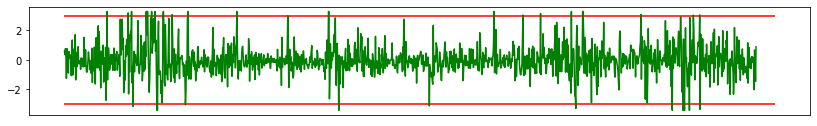

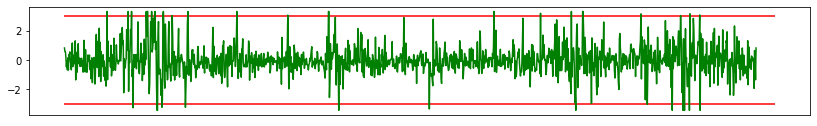

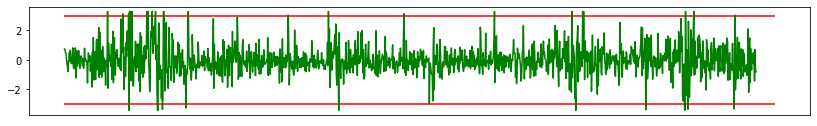

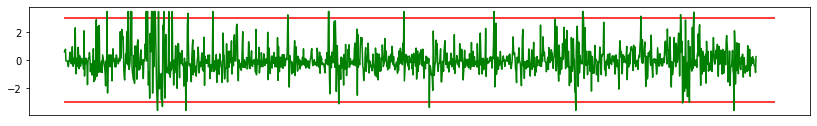

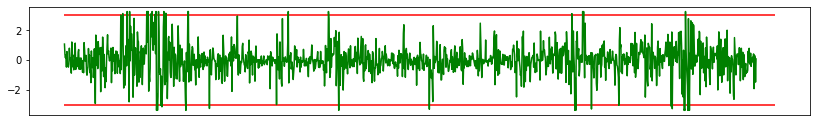

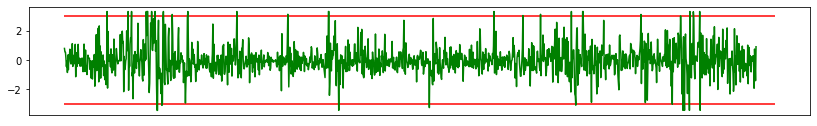

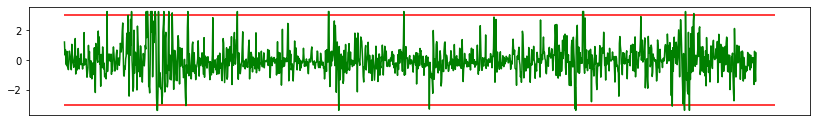

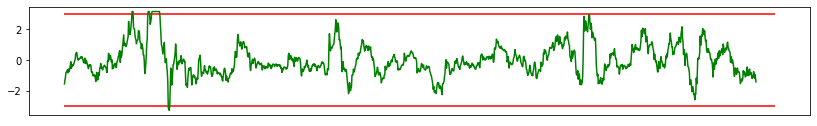

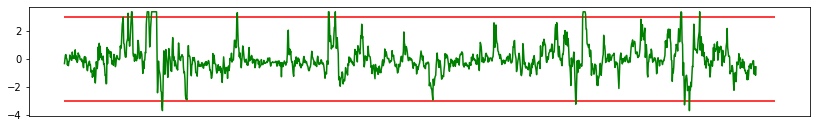

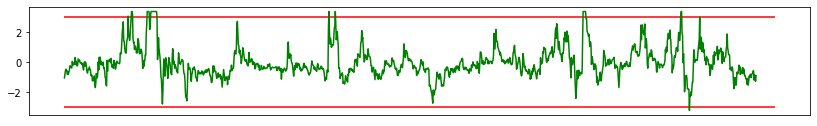

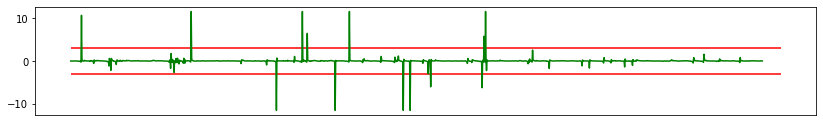

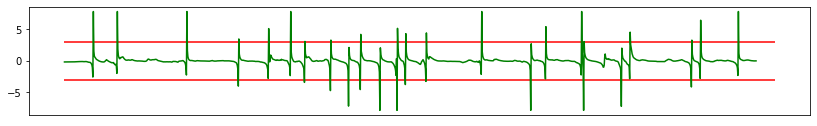

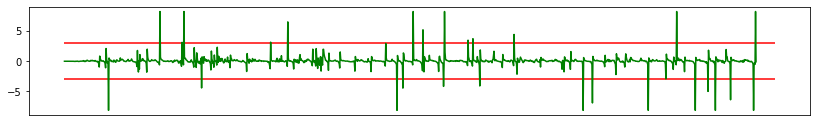

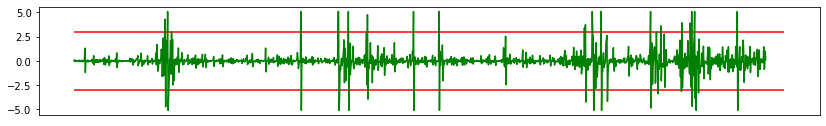

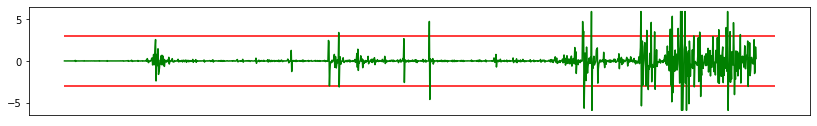

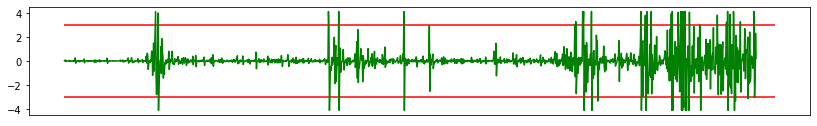

In [15]:
# Plot normalized - looks good - this is what goes into the model 
for i in range(16):
    plt.figure(figsize=(14, 2))
    plt.plot(norm[:,i:i+1], 'g')
    plt.hlines(- 3 * norm[:,i:i+1].std(), 0, 1450, 'r')
    plt.hlines(3 * norm[:,i:i+1].std(), 0, 1450, 'r')
    plt.xticks([])
    plt.show()